# IMDb Sentiment Analysis with Bidirectional LSTM

This notebook builds a sentiment classifier for IMDb movie reviews using TensorFlow/Keras. We walk through loading the dataset, preparing padded sequences, training a bidirectional LSTM, and evaluating performance.

**Pipeline overview**

1. Setup and imports  
2. Load and inspect the IMDb dataset  
3. Preprocess sequences with padding and exploratory checks  
4. Train a bidirectional LSTM baseline  
5. Evaluate accuracy and error patterns, then outline next steps

Dataset: TensorFlow/Keras IMDb reviews (25k train / 25k test) with integer-encoded tokens sorted by frequency.


## 1. Setup and Imports

Configure core libraries, reproducibility seeds, and training hyperparameters used throughout the workflow.


In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Check working directory
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\asus\OneDrive - Universidade de Aveiro\Documents\GitHub\RNN_Practicise_exercises-solution


## 2. Load Data and Exploratory Analysis


In [90]:
# 1️⃣ Load each split dataset from CSV
df_o = pd.read_csv("imdb_adaptation.csv")

print("\n🔹 Training set structure:")
df_o.info()          # Overview of columns, dtypes, and non-null counts
print("\n🔹 First rows of training data:")
print(df_o.head())   # Display first few rows to confirm format


🔹 Training set structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  10000 non-null  object
 1   label     10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB

🔹 First rows of training data:
                                            sequence  label
0  [1, 261, 4, 156, 81, 6, 1078, 292, 395, 4, 478...      0
1  [1, 1795, 7, 8267, 10, 10, 13, 377, 73, 8599, ...      1
2  [1, 168, 48, 13, 71, 928, 11, 6, 2406, 2266, 2...      1
3  [1, 75, 296, 14, 23, 4, 389, 182, 7, 910, 23, ...      1
4  [1, 13, 427, 119, 14, 500, 8, 341, 126, 237, 1...      1


## 3. Preprocessing
This step uses padding and systematic data splitting to prepare the dataset for neural network training.
It ensures that all sequences share the same dimensionality, that the data distribution remains consistent, and that the model can be properly validated and tested on unseen data.

### 3.1 Padding

In [91]:
# Convert string representations of lists back to actual lists
from ast import literal_eval
df_o["sequence"] = df_o["sequence"].apply(literal_eval)

# Apply padding separately
MAX_LEN = 200
X_padded = pad_sequences(df_o["sequence"], maxlen=MAX_LEN)

# Extract labels
y = df_o["label"].values

# Display some information about the processed data
print("First converted sequence:", df_o["sequence"].iloc[0])
print("Shape after padding:", X_padded.shape)


First converted sequence: [1, 261, 4, 156, 81, 6, 1078, 292, 395, 4, 4780, 15, 5230, 638, 4, 268, 4, 192, 15, 134, 105, 26, 1167, 8, 3468, 19, 69, 72, 267, 33, 61, 106, 6, 2691, 891, 234, 83, 4, 22, 5, 53, 74, 280, 103, 15, 4, 114, 943, 9, 4229, 5, 550, 4, 6894, 2, 7, 4, 293, 1730, 64, 464, 9, 2201, 2, 4, 2810, 489, 7, 91, 7, 4, 105, 1729, 5, 4, 2, 96, 11, 63, 36, 26, 9121, 9, 616, 10, 10, 12, 9, 801, 7, 2, 2, 8, 276, 2589, 9257, 9502, 7409, 105, 190, 14, 7305, 2, 4762, 9, 6, 194, 1491, 180, 39, 2, 42, 2, 121, 4, 105, 2, 5, 7785, 257, 85, 18, 73, 2, 1007, 15, 297, 46, 315, 15, 22, 11, 2, 2, 75, 26, 918, 8, 794, 4, 2, 7, 6, 371, 2, 1663, 17, 29, 9229, 6, 5498, 4339, 5, 8144, 255, 1505, 14, 9, 688, 8, 27, 205, 3494, 21, 4, 229, 152, 1425, 15, 13, 528, 202, 245, 4, 360, 7, 4, 65, 43, 11, 420, 50, 26, 101, 2, 46, 2, 9, 29, 2, 143, 27, 2970, 42, 9, 4, 255, 2414, 46, 7, 41, 205, 3494, 143, 27, 2, 692, 60, 151, 13, 296, 4, 226, 155, 13, 286, 93, 8, 459, 60, 18, 6, 561, 44, 345, 7, 98, 10, 10,

### 3.2 Split Train/Val/Test -> 80/10/10

In [92]:
# 1️⃣ First split → 80% train / 20% temp (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_padded, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y    
)

# 2️⃣ Split the 20% into 10% val / 10% test (stratified)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=y_temp 
)

print("✅ Stratified data split done:")
for name, arr in zip(["Train", "Validation", "Test"], [y_train, y_val, y_test]):
    unique, counts = np.unique(arr, return_counts=True)
    ratio = counts / counts.sum()
    print(f"{name} class ratio: {dict(zip(unique, np.round(ratio, 3)))}")

#  DISPLAY FINAL SHAPES
print("\n✅ Final dataset shapes:")
print(f"Train:       {X_train.shape}")
print(f"Validation:  {X_val.shape}")
print(f"Test:        {X_test.shape}")

✅ Stratified data split done:
Train class ratio: {0: 0.5, 1: 0.5}
Validation class ratio: {0: 0.5, 1: 0.5}
Test class ratio: {0: 0.5, 1: 0.5}

✅ Final dataset shapes:
Train:       (8000, 200)
Validation:  (1000, 200)
Test:        (1000, 200)


## 4. Build the Bidirectional LSTM Model

Stack an embedding layer with a bidirectional LSTM to capture contextual information from both directions, then pool and classify with dense layers.


In [93]:
# ============================================
# BUILD MODEL
model = Sequential([
    tf.keras.layers.Input(shape=(MAX_LEN,)),
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=32,
            dropout=0.4,
            recurrent_dropout=0.4
        )
    ),

    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model with optimizer, loss, and evaluation metric
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# ============================================
# TRAIN THE MODEL
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),   
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ (None, 200, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 64)             │        12,544 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,601 (678.13 KB)

 Trainable params: 173,601 (678.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - accuracy: 0.5353 - loss: 0.6915 - val_accuracy: 0.5570 - val_loss: 0.6859 - learning_rate: 5.0000e-04
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.7016 - loss: 0.6231 - val_accuracy: 0.7340 - val_loss: 0.5696 - learning_rate: 5.0000e-04
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.7894 - loss: 0.5174 - val_accuracy: 0.8200 - val_loss: 0.4564 - learning_rate: 5.0000e-04
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.8301 - loss: 0.4358 - val_accuracy: 0.7950 - val_loss: 0.4459 - learning_rate: 5.0000e-04
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.8646 - loss: 0.3665 - val_accuracy: 0.8150 - val_loss: 0.4063 - learning_rate: 5.0000e-04
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.8871 - loss: 0.3174 - val_accuracy: 0.8350 - val_loss: 0.3627 - learning_rate: 5.0000e-04
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 12

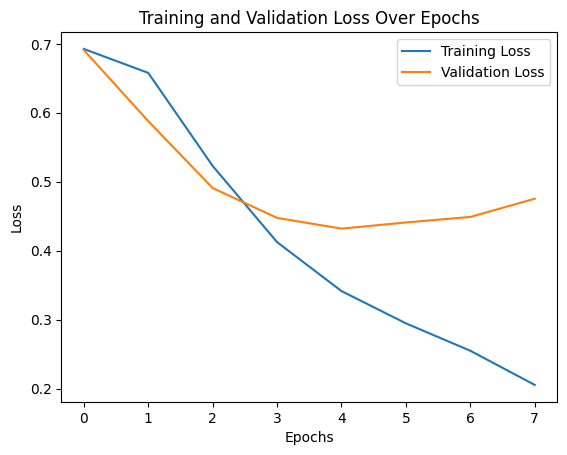

In [88]:
# PLOT TRAINING CURVES
plt.plot(history.history['loss']) # Plotting training loss
plt.plot(history.history['val_loss']) # Plotting validation loss
plt.title("Training and Validation Loss Over Epochs") # Adding title
plt.xlabel("Epochs") # Adding x-axis label
plt.ylabel("Loss") # Adding y-axis label
plt.legend(["Training Loss", "Validation Loss"])
plt.show() # Displaying the plot

## 6. Evaluate and Interpret Results

After training, the model’s performance is assessed on the test set to verify its ability to generalize to unseen data.
Besides the loss and accuracy metrics automatically tracked during training, a more detailed analysis is carried out using additional classification metrics such as MAE, MSE and R2.

These metrics provide a clearer understanding of how well the model distinguishes between positive and negative reviews, complementing the overall accuracy measure.

In [72]:
# Evaluate on test set using Keras built-in evaluation
loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy (Keras): {test_accuracy:.4f}")

# Manual evaluation using sklearn metrics
y_pred = (model.predict(X_test) > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy (Sklearn): {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nConfusion Matrix:\n", cm)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7910 - loss: 0.4326
Test Accuracy (Keras): 0.7910
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Accuracy (Sklearn): 0.7910
Precision: 0.7814
Recall:    0.8080
F1-score:  0.7945

Confusion Matrix:
 [[387 113]
 [ 96 404]]


## Next Steps

- Explore alternative model architectures (stacked LSTMs, GRUs, or convolutional front-ends) 
- Increase `NUM_WORDS` or `MAX_LEN` and observe the trade-off between vocabulary coverage and training cost.
- Add regularisation such as dropout, or incorporate pre-trained word embeddings (e.g., GloVe) for richer representations.
